# Pathway Analysis of Topcoder Challenge Data

In [1]:
%reload_ext autoreload
%autoreload 2
import scanpy as sc
import pandas as pd
from metrics import *
from activity import *
import scprep
import magic
from warnings import filterwarnings
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap
from sklearn.decomposition import PCA


filterwarnings('ignore')

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.26.4 scipy==1.13.1 pandas==2.2.2 scikit-learn==1.5.0 statsmodels==0.14.2 igraph==0.11.6 louvain==0.8.2 pynndescent==0.5.13


### Data Preparation
The challenge data is available on AWS cloud servers. You need to register to the challenge here:
- https://www.topcoder.com/challenges/25f60820-2e69-444b-bc03-490686af2c87?tab=details

and then go the the forum links and download sc_training.h5ad from:

- https://discussions.topcoder.com/discussion/25381/challenge-specifications-and-data-for-cancer-immunotherapy-data-science-grand-challenge

In [2]:
adata = sc.read_h5ad('./data/sc_training.h5ad')
#adata = sc.pp.subsample(adata, fraction=0.3, copy=True)
#28697 cells × 15077 genes.
adata

AnnData object with n_obs × n_vars = 28697 × 15077
    obs: 'gRNA_maxID', 'state', 'condition', 'lane'
    layers: 'rawcounts'

adata.X stores the standard-normalized data. We can also reconstruct it using adata.layers['rawcounts'].
- Make a copy of X:
```
    adata.layers['normalized_logcounts'] = adata.X.copy()
```
- Use rawcounts for standard normalization:
```
    adata.X = adata.layers['rawcounts'].copy()
    sc.pp.normalize_total(adata, target_sum=5e3)
    sc.pp.log1p(adata)
    adata.raw.X[:5,:5].toarray()
```

In [31]:
adata.obs.head()

,gRNA_maxID,state,condition,lane,kmeans3
053l1_AAACCTGAGATGTCGG-1,ONE-NON-GENE-SITE-7,terminal exhausted,Unperturbed,lane1,3
053l1_AAACCTGAGCAACGGT-1,Tox2-3,effector,Tox2,lane1,1
053l1_AAACCTGAGTACGACG-1,Tpt1-2,effector,Tpt1,lane1,2
053l1_AAACCTGAGTCGTTTG-1,Tox2-3,terminal exhausted,Tox2,lane1,2
053l1_AAACCTGAGTGAAGAG-1,Tcf7-2,effector,Tcf7,lane1,2


### Run Magic

In [ ]:
%%time
activity_df = pd.DataFrame(adata.X.toarray(), index=adata.obs_names, columns=adata.var_names)
activity_df = scprep.normalize.library_size_normalize(activity_df)
activity_df = scprep.transform.sqrt(activity_df)

magic_op = magic.MAGIC()
activity_df = magic_op.fit_transform(activity_df)
activity_df.to_csv('./data/activity_df.csv', index=True)

#sce.pp.magic(adata, name_list='all_genes', knn=5)

### Run PathSingle

In [3]:
activity = sc.read('./data/activity_df.csv', delimiter=',', cache=False)
calc_activity(activity)

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


### Cluster With KMeans

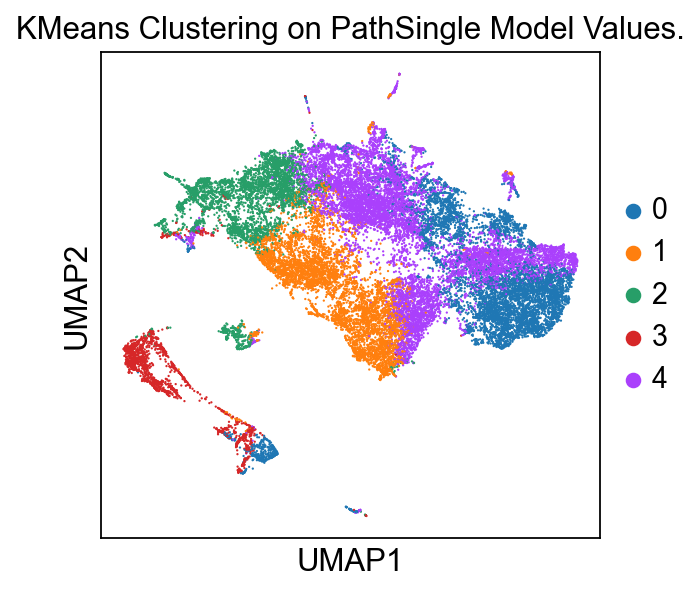

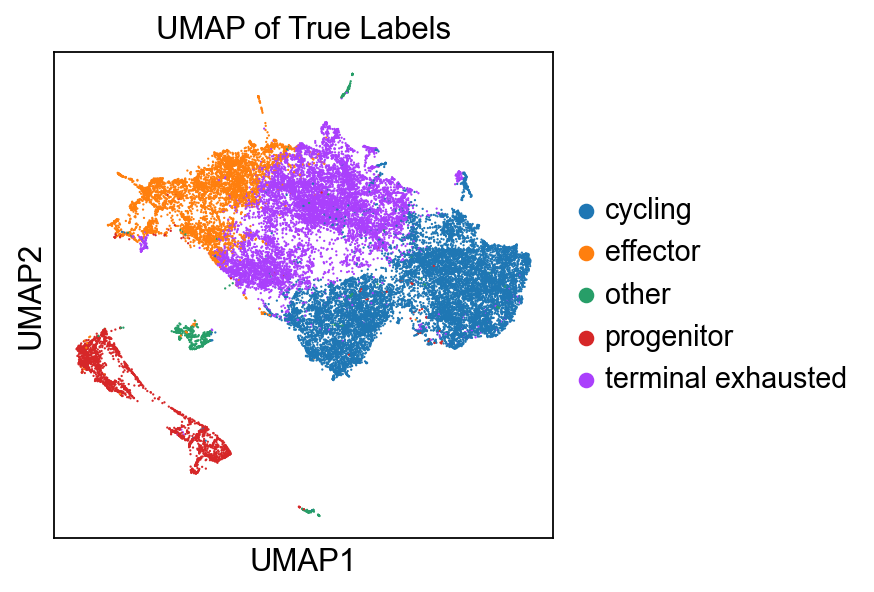

In [12]:
from sklearn.decomposition import PCA


output_activity = pd.read_csv('./data/output_interaction_activity.csv', index_col=0)

#Scale the data.
scaler = StandardScaler()
output_activity = scaler.fit_transform(output_activity)
PCA = PCA(n_components=50, svd_solver='arpack')
output_activty = PCA.fit_transform(output_activity)

#Perform KMeans clustering on the UMAP coordinates.
kmeans = KMeans(n_clusters=5, random_state=0).fit(output_activity)

#Perform UMAP on the results matrix.
umap_model = umap.UMAP(n_neighbors=15) #For reproducability need to set , random_state=0, n_jobs=1.
umap_coords = umap_model.fit_transform(output_activity)

#Add the UMAP coordinates and clustering results to the AnnData object.
adata.obsm['X_umap'] = umap_coords
adata.obs['kmeans3'] = pd.Categorical(kmeans.labels_)
#cell_state = adata.obs['state']
#cdata.obs['state'] = cell_state[emt_magic.index].values

#Plotting UMAP with KMeans clustering results using scanpy.
sc.pl.umap(adata, color=["kmeans3"], title="KMeans Clustering on PathSingle Model Values.")
sc.pl.umap(adata, color=["state"], title="UMAP of True Labels")

### Cluster Results

In [13]:
#Extract pathway activity matrix for metric calculation.
pathway_activity_matrix = output_activity

#We use cdata.obs.data, the true labels.
true_labels = adata.obs.state.map({'cycling':0, 'effector':1, 'other':2, 'progenitor':3, 'terminal exhausted':4})

print_stats(pathway_activity_matrix, true_labels, kmeans.labels_)

Silhouette Score: 0.14569608620545252
Calinski-Harabasz Index: 5626.260829663223
Special accuracy: 0.5323204516151514
completeness score: 0.3316261214796147
homogeneity_score: 0.3788554711650263
adjusted_mutual_info_score: 0.3535418106982368


## PROGENy

In [3]:
import decoupler

#top: Desired top number of genes for each pathway according to their significance(p.value). Default to 100.
progeny = decoupler.get_progeny(organism='human', top=2000)
progeny.head()

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40


In [4]:
# Normalize gene names to lowercase.
adata.var_names = [gene.lower() for gene in adata.var_names]
progeny['target'] = progeny['target'].str.lower()

# Inspect unique gene names in both datasets.
unique_adata_genes = set(adata.var_names)
unique_progeny_genes = set(progeny['target'])

# Check overlap.
shared_genes = unique_adata_genes & unique_progeny_genes
print(f"Number of shared genes: {len(shared_genes)}")
print(f"Number of unique genes in adata: {len(unique_adata_genes)}")
print(f"Number of unique genes in progeny: {len(unique_progeny_genes)}")

# Identify missing genes.
missing_in_progeny = unique_adata_genes - unique_progeny_genes
missing_in_adata = unique_progeny_genes - unique_adata_genes
print(f"Genes in adata but not in progeny: {len(missing_in_progeny)}")
print(f"Genes in progeny but not in adata: {len(missing_in_adata)}")

print("Example genes in adata but not in progeny:", list(missing_in_progeny)[:10])
print("Example genes in progeny but not in adata:", list(missing_in_adata)[:10])

Number of shared genes: 9389
Number of unique genes in adata: 15077
Number of unique genes in progeny: 13865
Genes in adata but not in progeny: 5688
Genes in progeny but not in adata: 4476
Example genes in adata but not in progeny: ['arg2', '2610021a01rik', 'zfp790', 'srp9', 'atp5h', 'gm37637', 'gm13008', 'dlgap3', 'prorsd1', 'gm11175']
Example genes in progeny but not in adata: ['rag2', 'mfsd6l', 'slc34a1', 'pnpla4', 'upk2', 'nipsnap3a', 'rnf113b', 'cltrn', 'bmpr1b', 'h2ac25']


In [5]:
# Filter mat to include only shared genes.
filtered_mat = adata[:, list(shared_genes)].copy()

# Check for empty features.
non_empty_features = filtered_mat[:, filtered_mat.X.sum(axis=0) > 0]

# Run PROGENy with the filtered matrix.
decoupler.run_mlm(
        mat=non_empty_features,
        net=progeny,
        source='source',
        target='target',
        weight='weight',
        verbose=True,
        use_raw=False
    )

Running mlm on mat with 28697 samples and 9386 targets for 14 sources.


100%|██████████| 3/3 [00:14<00:00,  4.93s/it]


### Cluster With KMeans

Pathway activity matrix shape: (28697, 14)


  File "c:\Users\user\Documents\GitHub\PathSingle\venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


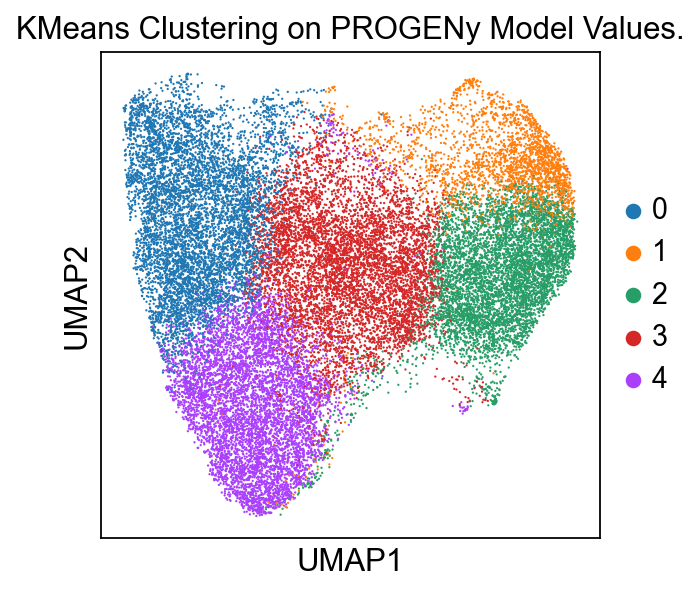

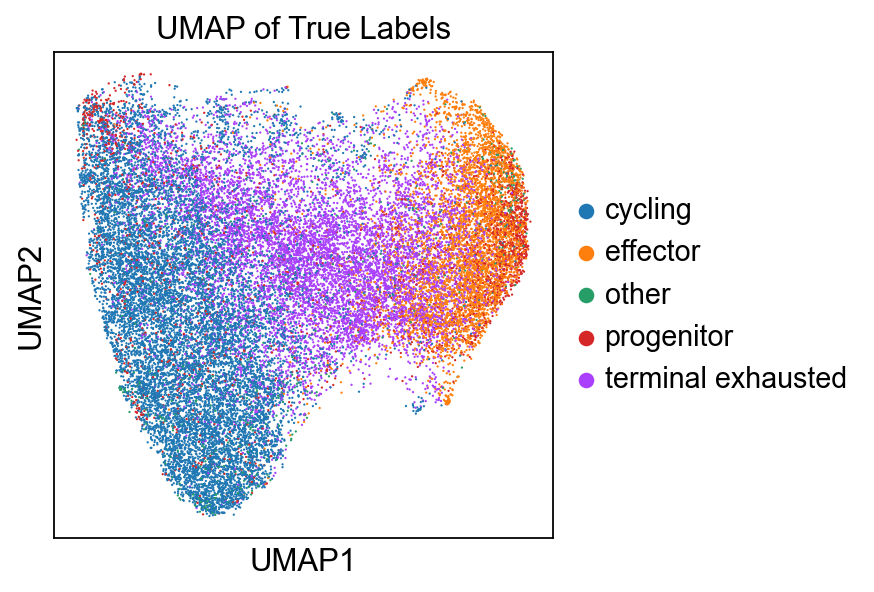

In [6]:
from sklearn.cluster import KMeans
import umap.umap_ as umap


acts = decoupler.get_acts(non_empty_features, obsm_key='mlm_estimate')

#Verify the structure of pathway activity matrix.
print("Pathway activity matrix shape:", acts.obsm['mlm_estimate'].shape)

#Convert the pathway activity matrix to a DataFrame.
pathway_activity_df = pd.DataFrame(
    acts.obsm['mlm_estimate'],
    index=adata.obs_names,
    columns=acts.var_names
)

#Add pathway activity to adata.obs.
#for pathway in acts.var_names:
    #adata.obs[pathway] = pathway_activity_df[pathway]

#Perform KMeans clustering on the UMAP coordinates.
kmeans = KMeans(n_clusters=5, random_state=0).fit(pathway_activity_df)

#Perform UMAP on the results matrix.
umap_model = umap.UMAP(n_neighbors=15) #For reproducability need to set , random_state=0, n_jobs=1.
umap_coords = umap_model.fit_transform(pathway_activity_df)

#Add the UMAP coordinates and clustering results to the AnnData object.
adata.obsm['X_umap'] = umap_coords
adata.obs['kmeans3'] = pd.Categorical(kmeans.labels_)

#Plotting UMAP with KMeans clustering results using scanpy.
sc.pl.umap(adata, color=["kmeans3"], title="KMeans Clustering on PROGENy Model Values.")
sc.pl.umap(adata, color=["state"], title="UMAP of True Labels")

### Cluster Results

In [7]:
#Extract pathway activity matrix for metric calculation.
pathway_activity_matrix = acts.obsm['mlm_estimate']

#We use cdata.obs.data, the true labels.
true_labels = adata.obs.state.map({'cycling':0, 'effector':1, 'other':2, 'progenitor':3, 'terminal exhausted':4})

print_stats(pathway_activity_matrix, true_labels, kmeans.labels_)

Silhouette Score: 0.1569419652223587
Calinski-Harabasz Index: 7133.00548216748
Special accuracy: 0.49719482872774157
completeness score: 0.28092946597690915
homogeneity_score: 0.3361418710486943
adjusted_mutual_info_score: 0.3059303292691273
